# Notebook exploring MNE-Python's ICA Capability
___

In [1]:
# Imports
import pandas as pd
import numpy as np
import mne
from mne.preprocessing import ICA

import tools
import matplotlib.pyplot as plt
%matplotlib qt


In [2]:
with open("../config.json", 'rb') as f:
    config = pd.read_json(f, typ='series')

iEEG_filename = "HUP212_CCEP"
start_time_usec = 18891 * 1e6
stop_time_usec = 19882 * 1e6


In [3]:
data, fs = tools.get_iEEG_data(config.usr, config.pwd, iEEG_filename, start_time_usec, stop_time_usec)


In [5]:
# clean channel labels
clean_channels = tools.clean_labels(data.columns)
# find and return a boolean mask for non ieeg channels
non_ieeg_channels = tools.find_non_ieeg(clean_channels)

data.columns = clean_channels
data = data.iloc[:, ~non_ieeg_channels]


- [sklearn](https://scikit-learn.org/stable/modules/decomposition.html#independent-component-analysis-ica)
- [MNE-Py tut](https://mne.tools/stable/auto_tutorials/preprocessing/40_artifact_correction_ica.html#repairing-artifacts-with-ica)
- [MNE-Python API Reference](https://mne.tools/stable/generated/mne.preprocessing.ICA.html#mne.preprocessing.ICA)

In [6]:
mneInfo = mne.create_info(data.columns.to_list(), fs, 'eeg')
raw = mne.io.RawArray(data.T, mneInfo)

Creating RawArray with float64 data, n_channels=118, n_times=1014784
    Range : 0 ... 1014783 =      0.000 ...   990.999 secs
Ready.


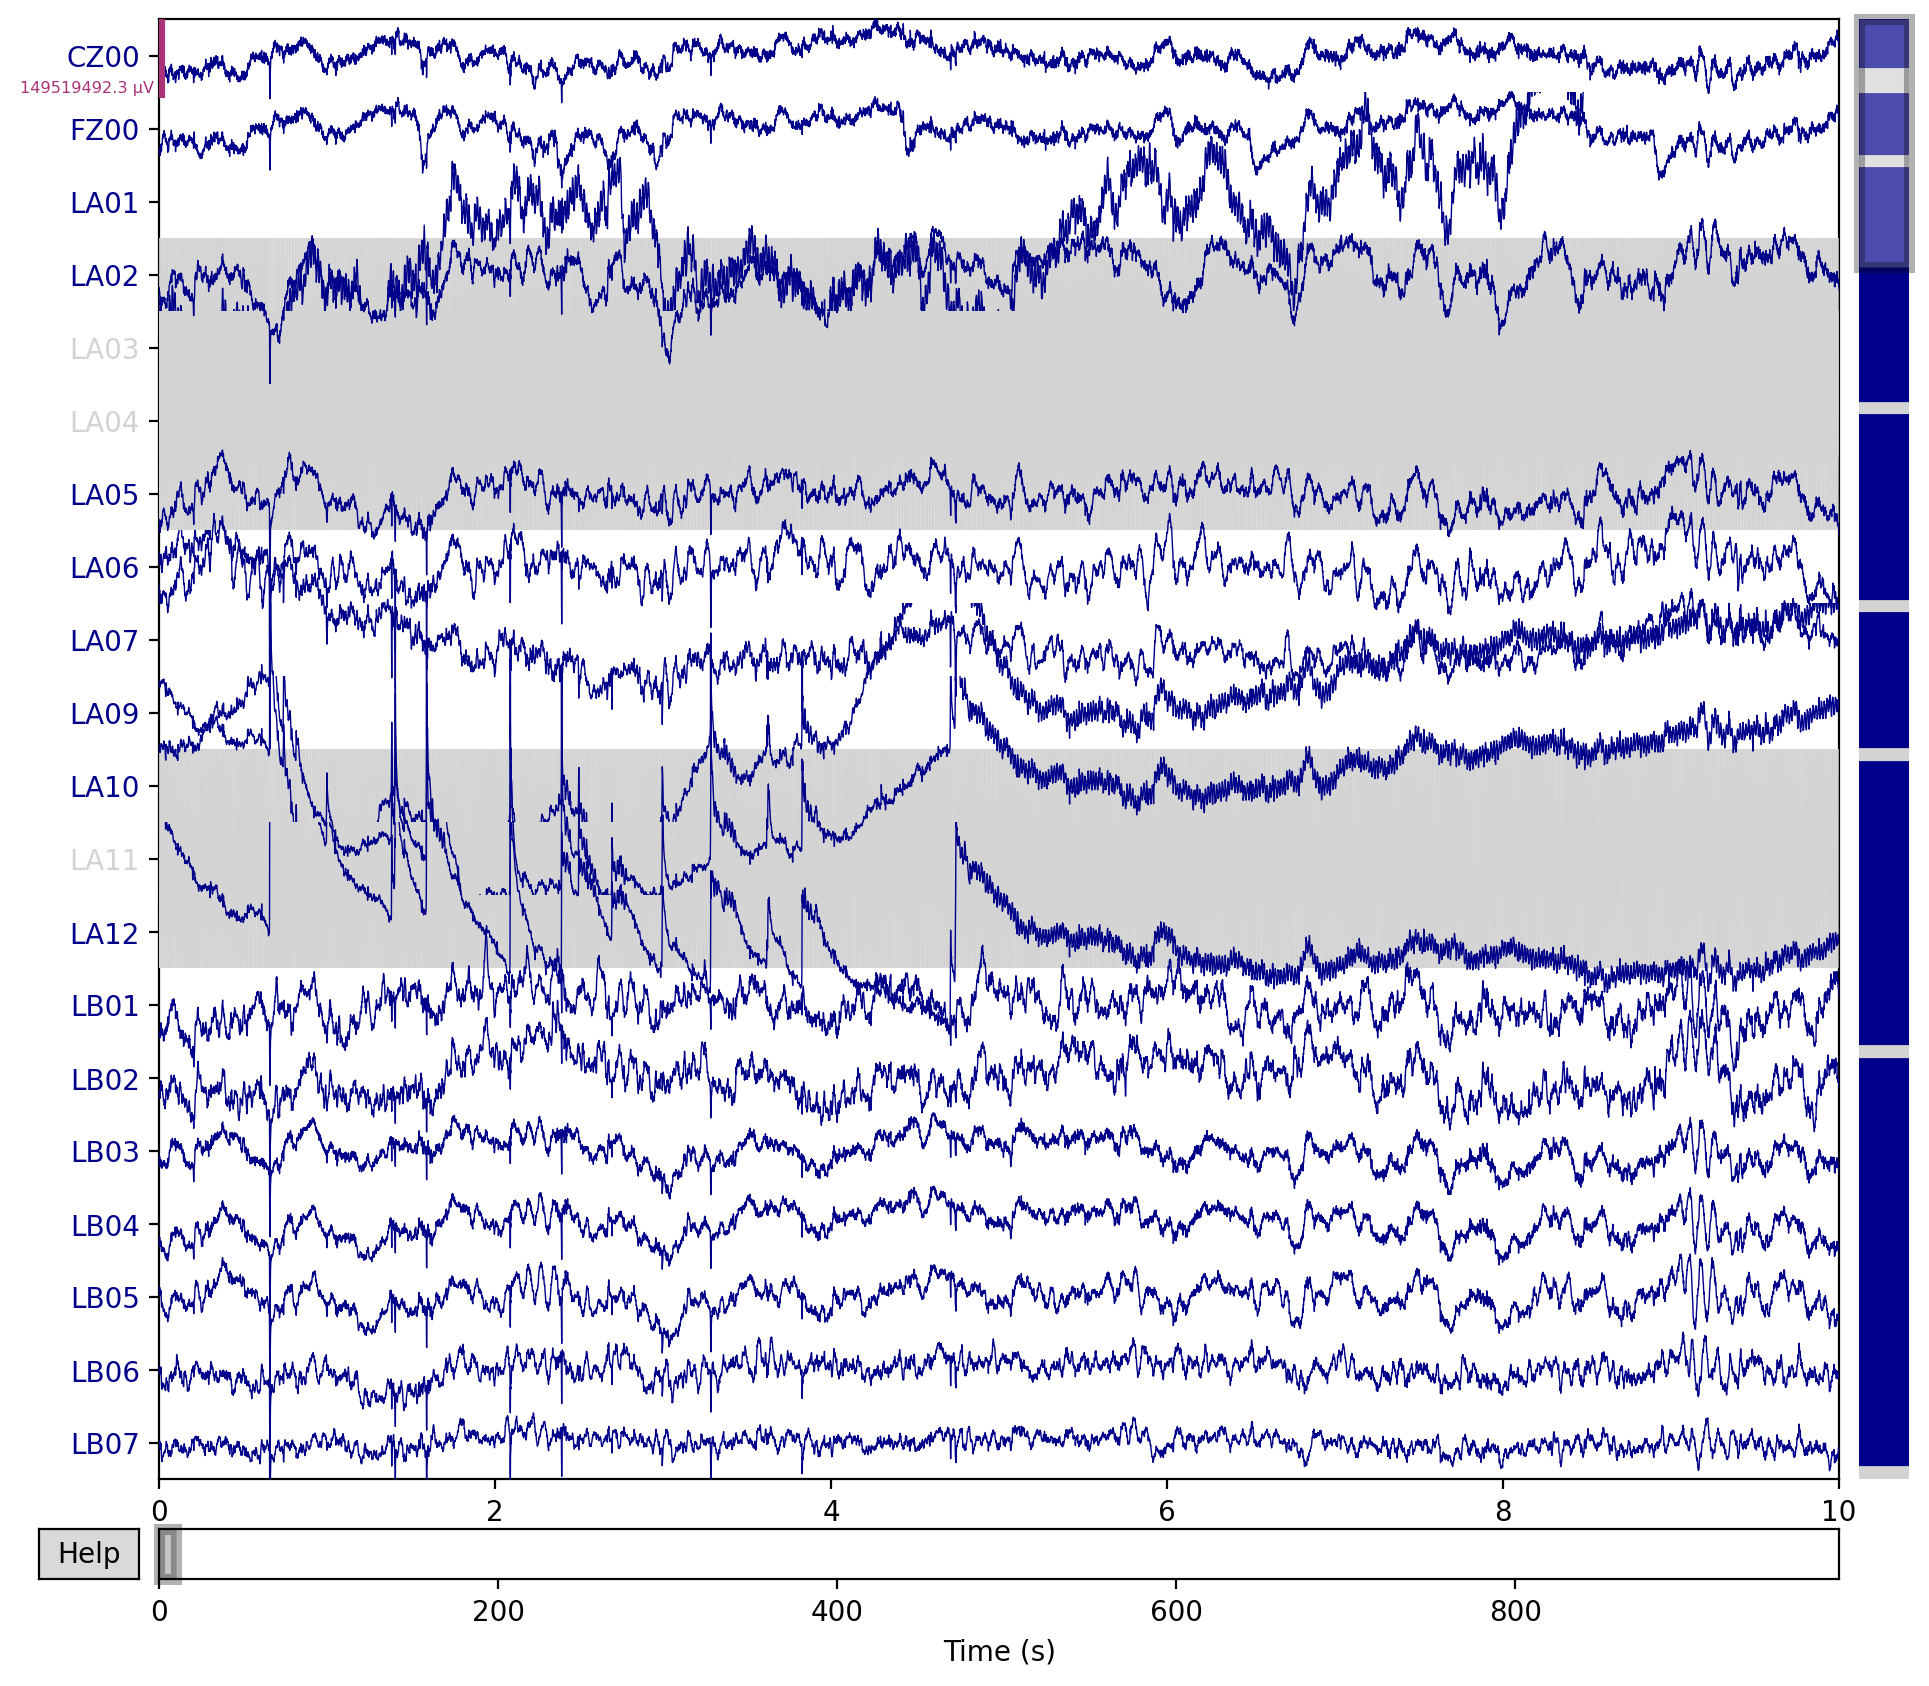

In [59]:
raw.plot(scalings = 'auto', color = 'darkblue')

Effective window size : 0.250 (s)


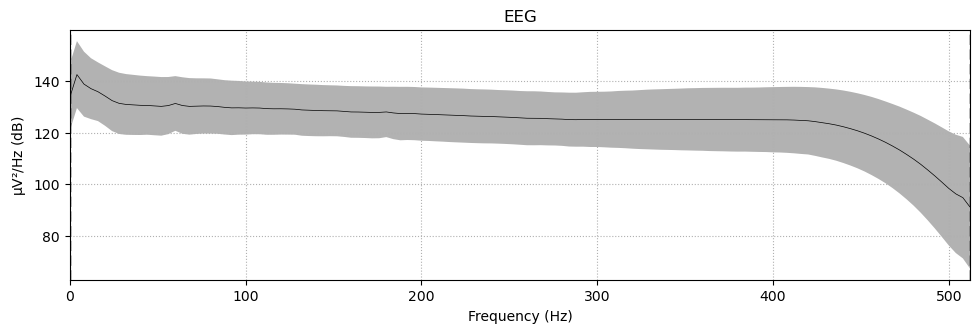

In [8]:
spectrum = raw.compute_psd()
spectrum.plot(average=True)

In [21]:
filt_raw = raw.copy().filter(l_freq=1., h_freq=None)
ica = ICA(n_components=10, random_state = 97)
ica.fit(filt_raw)
ica

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 3381 samples (3.302 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s


Fitting ICA to data using 110 channels (please be patient, this may take a while)


[Parallel(n_jobs=1)]: Done 118 out of 118 | elapsed:    1.7s finished


Selecting by number: 10 components
Fitting ICA took 22.4s.


Method,fastica
Fit,33 iterations on raw data (1014784 samples)
ICA components,10
Available PCA components,110
Channel types,eeg
ICA components marked for exclusion,—


In [22]:
ica.get_explained_variance_ratio(filt_raw)

{'eeg': 0.8112096324032604}

Creating RawArray with float64 data, n_channels=10, n_times=1014784
    Range : 0 ... 1014783 =      0.000 ...   990.999 secs
Ready.


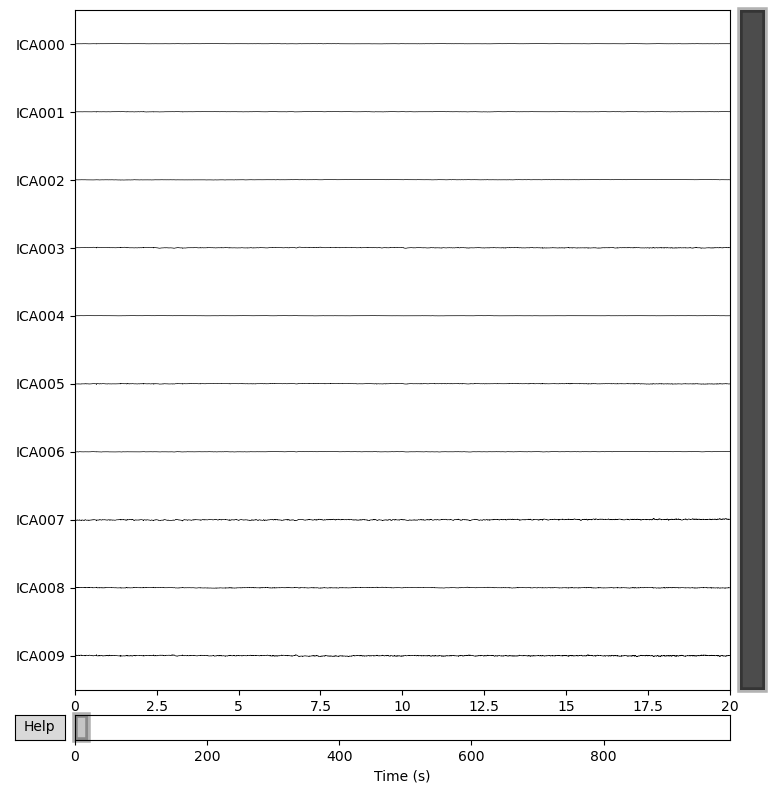

In [36]:
ica.plot_sources(raw)

Applying ICA to Raw instance
    Transforming to ICA space (10 components)
    Zeroing out 2 ICA components
    Projecting back using 110 PCA components


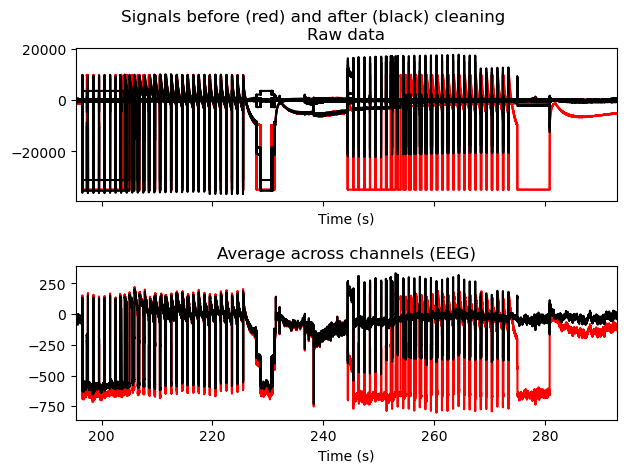

In [54]:
ica.plot_overlay(raw, exclude = [0, 4], start = int(2e5), stop = int(3e5))

In [55]:
ica.exclude = [0, 1]  # indices chosen based on various plots above

Applying ICA to Raw instance
    Transforming to ICA space (10 components)
    Zeroing out 2 ICA components
    Projecting back using 110 PCA components


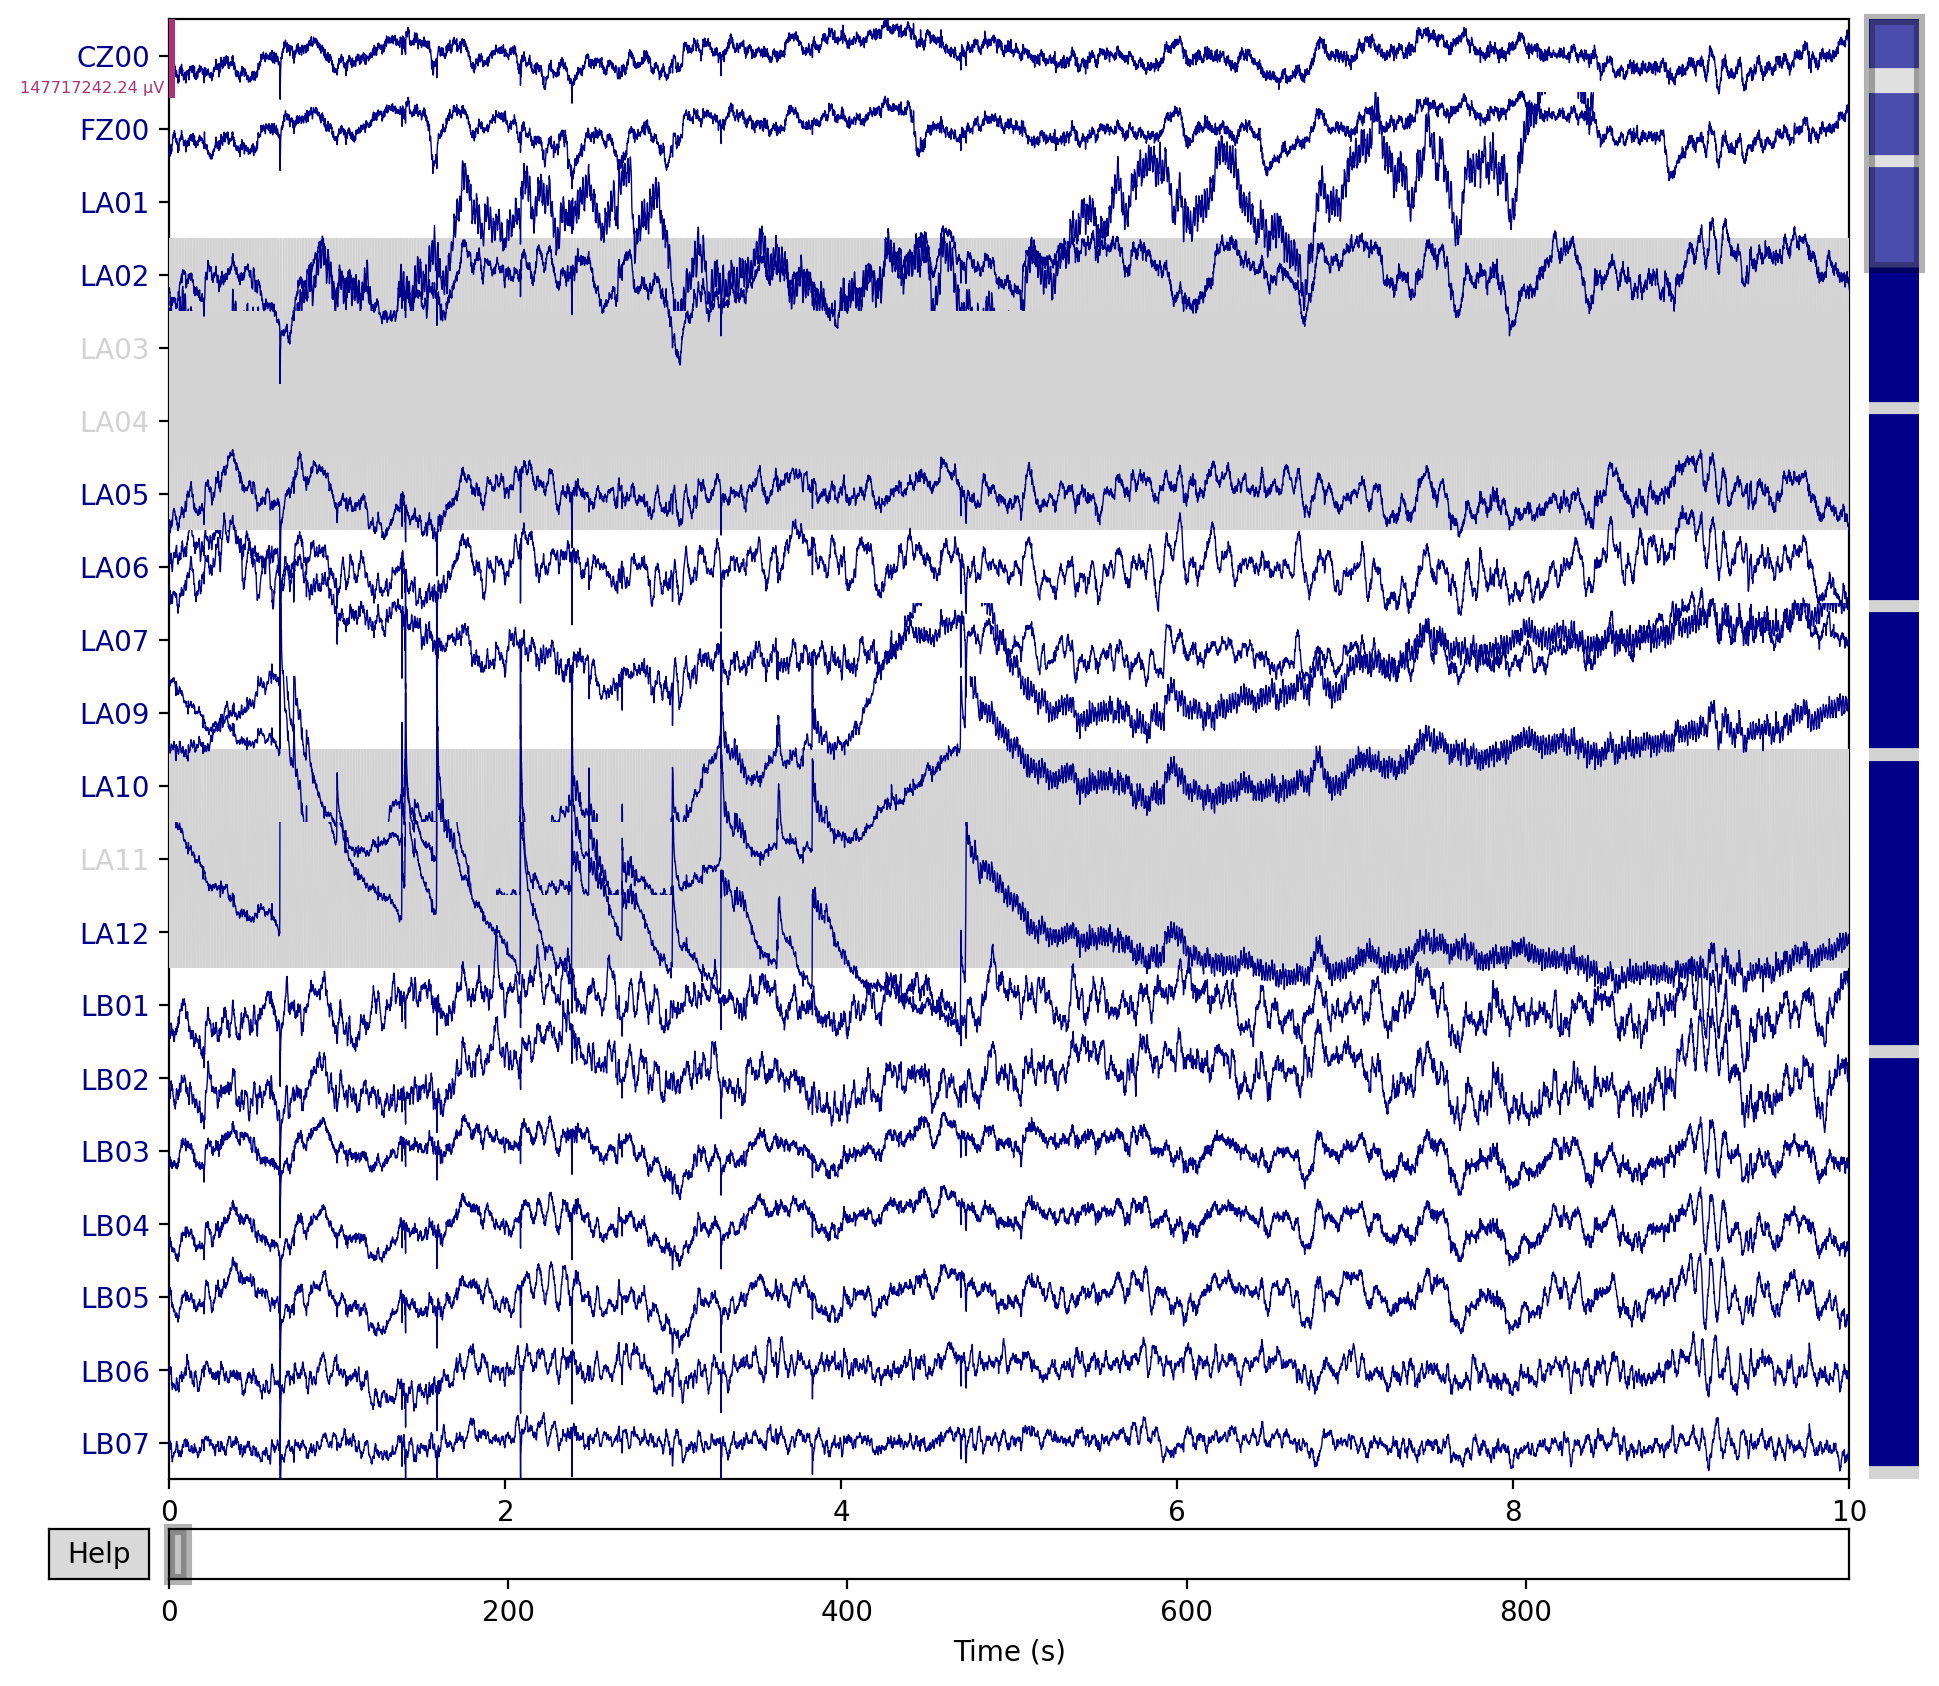

Channels marked as bad:
['LA04', 'LC08', 'LD12', 'LE12', 'LG12', 'ROC00', 'LA03', 'LA11', 'FZ00']
Channels marked as bad:
['LC08', 'LD12', 'LE12', 'LG12', 'ROC00', 'LA03', 'LA04', 'LA11', 'LA07']


In [60]:
reconst_raw = raw.copy()
ica.apply(reconst_raw)

reconst_raw.plot(scalings = 'auto', color = 'darkblue')